In [77]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [78]:
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import importlib
import os
from tqdm.notebook import tqdm
from collections import OrderedDict
import re
%matplotlib notebook
import json
import sys
# import imp
import random
import copy
import gc

In [79]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0')
print(torch.cuda.get_device_name(torch.device('cuda:0')))

NVIDIA GeForce RTX 3090


In [80]:
# sys.path.remove('/home/phil/Desktop/profile-predict/')

# Load data

In [81]:
data_valid_path = "/home/phil/Desktop/profile-predict/datasets/DR_combo_PP1_isat_04_valid_cv-0.npz"
valid_npz = np.load(data_valid_path)
x_mean = valid_npz['x_mean']
x_ptp = valid_npz['x_ptp']
y_mean = valid_npz['y_mean']
y_ptp = valid_npz['y_ptp']

In [82]:
RMSE = 0.054 * y_ptp

# Load model

In [83]:
ens_name = "beta-NLL_wd-0.0"
os.chdir('/home/phil/Desktop/profile-predict/PP1/training_runs/')

In [84]:
runs = sorted(os.listdir(ens_name))
if 'plots' in runs:
    runs.remove('plots')

In [85]:
runs

['2024-09-11_16h-34m-43s',
 '2024-09-11_17h-06m-22s',
 '2024-09-11_17h-37m-46s',
 '2024-09-11_18h-09m-16s',
 '2024-09-11_18h-40m-47s']

In [86]:
model_paths = [ens_name + "/" + run for run in runs]

model_versions = ["checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738"]

In [87]:
models = []
for model_path, model_version in zip(model_paths, model_versions):
    print("Loading model " + model_path + " version " + model_version)
    os.chdir("/home/phil/Desktop/profile-predict/PP1/training_runs/" + model_path + "/")

    spec = importlib.util.spec_from_file_location("train_dense_beta_NLL_copy", "train_dense_beta_NLL_copy.py")
    loaded_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(loaded_module)
    with open("hyperparams.json") as json_f:
        hyperparams = json.loads(json_f.read())

    # imp.reload(ebm)
    model = loaded_module.ModelClass(hyperparams).to(device)
    # ckpt = torch.load("experiments_modular/" + model_path + "/" + model_version + ".pt")
    ckpt = torch.load(model_version + ".pt")

    model_dict = OrderedDict()
    pattern = re.compile('module.')
    state_dict = ckpt['model_state_dict']
    for k,v in state_dict.items():
        if re.search("module", k):
            model_dict[re.sub(pattern, '', k)] = v
        else:
            model_dict = state_dict
    model.load_state_dict(model_dict, strict=True)

    data_train_path = "/home/phil/Desktop/profile-predict/datasets/" + hyperparams['dataset']

    print("Number of parameters: {}".format(np.sum([p.numel() for p in model.parameters() if p.requires_grad])))
    
    models.append(model)
for model in models:
    model = model.cpu()

Loading model beta-NLL_wd-0.0/2024-09-11_16h-34m-43s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_17h-06m-22s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_17h-37m-46s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_18h-09m-16s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_18h-40m-47s version checkpoints/model-499-738
Number of parameters: 201218


In [88]:
ls checkpoints/

model-0-3.pt      model-319-288.pt  model-499-738.pt
model-160-519.pt  model-480-602.pt  model-best.pt


# Meshgrid

In [89]:
os.chdir('/home/phil/Desktop/profile-predict/PP1/')

In [90]:
# B_cathode = np.arange(500, 2001, 250)
# B_mirror = np.arange(250, 1501, 250)
# B_midplane = np.arange(250, 1501, 250)
# Gas_puff_voltage = np.arange(70, 91, 5)
# Discharge_voltage = np.arange(70, 151, 10)

In [91]:
B_source_arr = np.arange(500, 2001, 250)
B_mirror_arr = np.arange(250, 1501, 250)
B_midplane_arr = np.arange(250, 1501, 250)
GP_voltage_arr = np.arange(70, 91, 5)
discharge_voltage_arr = np.arange(70, 151, 10)
GP_duration = np.linspace(5, 38, 5)
x_arr = np.linspace(-50, 50, 51)
y_arr = np.array([0])
z_arr = np.linspace(640, 1140, 11)
theta_arr = np.array([0])
run_set_flag = np.array([0, 1])
top_GP_flag = np.array([0, 1])

In [92]:
np.linspace(640, 1140, 11)

array([ 640.,  690.,  740.,  790.,  840.,  890.,  940.,  990., 1040.,
       1090., 1140.])

In [93]:
695.55555556 - 640

55.555555560000016

In [94]:
z_arr

array([ 640.,  690.,  740.,  790.,  840.,  890.,  940.,  990., 1040.,
       1090., 1140.])

In [95]:
len(GP_duration)

5

In [96]:
(len(B_source_arr) * 
len(B_mirror_arr) * 
len(B_midplane_arr) * 
len(GP_voltage_arr) * 
len(discharge_voltage_arr) * 
len(GP_duration) * 
len(x_arr) * 
len(y_arr) * 
len(z_arr) * 
len(theta_arr) * 
len(run_set_flag) * 
len(top_GP_flag))

127234800

In [97]:
input_list = [B_source_arr, 
    B_mirror_arr, 
    B_midplane_arr,  
    GP_voltage_arr, 
    discharge_voltage_arr,
    GP_duration, 
    x_arr, 
    y_arr, 
    z_arr, 
    theta_arr, 
    run_set_flag, 
    top_GP_flag,]

In [98]:
# input_unscaled = np.array(np.meshgrid(B_source_arr, 
#                              B_mirror_arr, 
#                              B_midplane_arr, 
#                              discharge_voltage_arr, 
#                              GP_voltage_arr, 
#                              GP_duration, 
#                              x_arr, 
#                              y_arr, 
#                              z_arr, 
#                              theta_arr, 
#                              run_set_flag, 
#                              top_GP_flag,
#                             indexing='ij')).reshape(12, -1).transpose()

In [99]:
# input_unscaled = input_unscaled.reshape(*isat_shape, 12)

In [100]:
input_meshgrid = torch.tensor(np.array(np.meshgrid(B_source_arr, 
                             B_mirror_arr, 
                             B_midplane_arr, 
                             GP_voltage_arr, 
                             discharge_voltage_arr, 
                             GP_duration, 
                             x_arr, 
                             y_arr, 
                             z_arr, 
                             theta_arr, 
                             run_set_flag, 
                             top_GP_flag,
                            indexing='ij')).reshape(12, -1).transpose(), requires_grad=False, dtype=torch.float32)

In [101]:
input_meshgrid = (input_meshgrid - torch.tensor(x_mean, dtype=torch.float32)) / torch.tensor(x_ptp, dtype=torch.float32)

In [102]:
model_test = models[0].to('cuda')

In [103]:
models_cuda = [m.to('cuda') for m in models]

In [104]:
gc.collect()
torch.cuda.empty_cache()

In [47]:
del input_meshgrid

In [46]:
del output_meshgrid

NameError: name 'output_meshgrid' is not defined

# Inference

In [105]:
# outputs = []
# for m in tqdm(models_cuda):
#     output_meshgrid = []
#     for i in tqdm(range(input_meshgrid.shape[0] // 2500000)):
#         temp_outputs = m(input_meshgrid[i*2500000:(i+1)*2500000].to('cuda'))[:, :]
#         output_meshgrid.append(temp_outputs.to('cpu').detach().numpy())
#         del temp_outputs
#         gc.collect()
#         torch.cuda.empty_cache()

#     output_meshgrid.append(m(input_meshgrid[(i+1)*2500000:].to('cuda'))[:, :].to('cpu').detach().numpy())
#     output_meshgrid = np.concatenate(output_meshgrid, axis=0)
#     outputs.append(output_meshgrid)
#     del output_meshgrid
#     gc.collect()
#     torch.cuda.empty_cache()

# outputs = np.array(outputs)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [106]:
# np.savez('saved_data/inference_outputs_127M', outputs=outputs)

In [34]:
outputs = np.load('saved_data/inference_outputs_127M.npz')['outputs']

In [107]:
outputs.shape

(5, 127234800, 2)

In [185]:
mean_pred = np.mean(outputs[:, :, 0], axis=0)
var_pred = np.mean(outputs[:, :, 1] + outputs[:, :, 0] ** 2, axis=0) - mean_pred ** 2
aleatoric = np.mean(outputs[:, :, 1], axis=0)
epistemic = np.mean(outputs[:, :, 0] ** 2, axis=0) - mean_pred ** 2

In [186]:
isat_mean = mean_pred * y_ptp + y_mean
isat_var = var_pred * y_ptp ** 2
isat_aleatoric = aleatoric * y_ptp ** 2
isat_epistemic = epistemic * y_ptp ** 2

In [187]:
isat_shape = (len(B_source_arr), 
              len(B_mirror_arr), 
              len(B_midplane_arr), 
              len(GP_voltage_arr), 
              len(discharge_voltage_arr), 
              len(GP_duration), 
              len(x_arr), 
              len(y_arr), 
              len(z_arr), 
              len(theta_arr), 
              len(run_set_flag), 
              len(top_GP_flag))

In [188]:
isat_mean = isat_mean.reshape(*isat_shape)
isat_var = isat_var.reshape(*isat_shape)
isat_aleatoric = isat_aleatoric.reshape(*isat_shape)
isat_epistemic = isat_epistemic.reshape(*isat_shape)

In [189]:
isat_var.shape

(7, 6, 6, 5, 9, 5, 51, 1, 11, 1, 2, 2)

# Flattest axial profile

## Define indices for x=y=0

In [333]:
s = np.s_[:,  # B_source_arr
          :,  # B_mirror_arr
          :,  # B_midplane_arr
          :,  # GP_voltage_arr
          :,  # discharge_voltage_arr
          :,  # GP_duration
          25:26,  # x_arr
          0:1,  # y_arr
          :,  # z_arr
          0:1,  # theta_arr
          :,  # run_set_flag
          :] # top_GP_flag

In [334]:
s_one_z = np.s_[:,  # B_source_arr
          :,  # B_mirror_arr
          :,  # B_midplane_arr
          :,  # GP_voltage_arr
          :,  # discharge_voltage_arr
          :,  # GP_duration
          25:26,  # x_arr
          0:1,  # y_arr
          0:1,  # z_arr
          0:1,  # theta_arr
          :,  # run_set_flag
          :] # top_GP_flag

## Find flattest

Look at the data to 

In [335]:
flat_z_argmin = np.argmin(np.std(isat_mean[s], axis=8))

In [336]:
idx_z_argmin = np.unravel_index(flat_z_argmin, isat_mean[s_one_z].shape)

In [337]:
all_z_argmin = list(np.s_[*idx_z_argmin])
all_z_argmin[8] = np.s_[:]

In [338]:
isat_mean[s][*all_z_argmin]

array([0.0051047 , 0.00511386, 0.00511516, 0.00510078, 0.00506867,
       0.00504242, 0.00507452, 0.00511913, 0.00511185, 0.00511211,
       0.00507727], dtype=float32)

In [339]:
all_z_argmin

[1, 3, 0, 0, 6, 0, 0, 0, slice(None, None, None), 0, 1, 1]

<IPython.core.display.Javascript object>


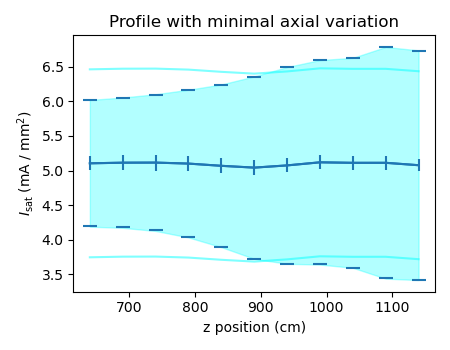

In [340]:
plt.figure(figsize=(4.5,3.5))
# plt.plot(z_arr, isat_mean[s][*all_z_argmin])

plt.title('Profile with minimal axial variation')
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.errorbar(z_arr, isat_mean[s][*all_z_argmin] * 1e3, yerr=np.sqrt(isat_aleatoric[s][*all_z_argmin]) * 1e3, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:blue')
plt.errorbar(z_arr, isat_mean[s][*all_z_argmin] * 1e3, yerr=np.sqrt(isat_epistemic[s][*all_z_argmin]) * 1e3, elinewidth=0, capsize=5, capthick=1.5, color='tab:blue')
plt.fill_between(z_arr, (isat_mean[s][*all_z_argmin] + np.sqrt(isat_var[s][*all_z_argmin])) * 1e3, (isat_mean[s][*all_z_argmin] - np.sqrt(isat_var[s][*all_z_argmin])) * 1e3, alpha=0.3, color='cyan')
# plt.fill_between(z_arr, isat_mean[s] + RMSE, isat_mean[s] - RMSE, alpha=0.2, color='cyan')
plt.plot(z_arr, (isat_mean[s][*all_z_argmin] + RMSE) * 1e3, alpha=0.5, color='cyan')
plt.plot(z_arr, (isat_mean[s][*all_z_argmin] - RMSE) * 1e3, alpha=0.5, color='cyan')

plt.ylabel(r'$I_\mathrm{sat}$ (mA / mm$^2$)')
plt.xlabel('z position (cm)')

plt.tight_layout()

# plt.ylim(0, 7)
# plt.savefig('/home/phil/Desktop/profile-predict/PP1/plots/inference/best_axial_var.pdf')

In [362]:
all_z_argmin

[1, 3, 0, 0, 6, 0, 0, 0, slice(None, None, None), 0, 1, 1]

In [418]:
[arr[all_z_argmin[i]] for i, arr in enumerate(input_list)]

[750,
 1000,
 250,
 70,
 130,
 5.0,
 -50.0,
 0,
 array([ 640.,  690.,  740.,  790.,  840.,  890.,  940.,  990., 1040.,
        1090., 1140.]),
 0,
 1,
 1]

## Flattest axial profile above 0.0075

In [391]:
isat_005_s = np.array(np.where(np.mean(isat_mean[s], axis=8, keepdims=True) > 0.0075))

In [392]:
isat_005_s[0:8]

array([[0, 0, 0, ..., 6, 6, 6],
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5],
       ...,
       [4, 2, 3, ..., 4, 4, 4],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [393]:
isat_005_s.shape

(12, 65372)

In [394]:
isat_mean_005 = np.array([isat_mean[s][*isat_005_s[0:8, i], :, *isat_005_s[9:, i]] for i in range(isat_005_s.shape[1])])
isat_aleatoric_005 = np.array([isat_aleatoric[s][*isat_005_s[0:8, i], :, *isat_005_s[9:, i]] for i in range(isat_005_s.shape[1])])
isat_epistemic_005 = np.array([isat_epistemic[s][*isat_005_s[0:8, i], :, *isat_005_s[9:, i]] for i in range(isat_005_s.shape[1])])
isat_var_005 = np.array([isat_var[s][*isat_005_s[0:8, i], :, *isat_005_s[9:, i]] for i in range(isat_005_s.shape[1])])

In [395]:
isat_aleatoric_005.shape

(65372, 11)

In [396]:
isat_mean_005_argsort = np.argsort(np.std(isat_mean_005, axis=1))

In [397]:
isat_mean_005[isat_mean_005_argsort].shape

(65372, 11)

<IPython.core.display.Javascript object>


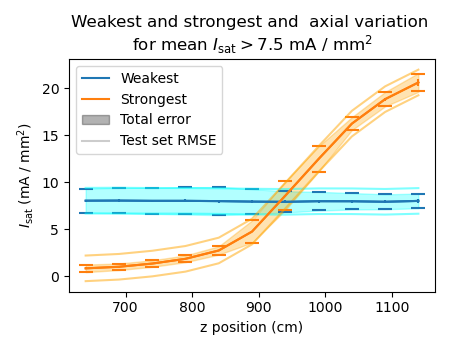

In [409]:
plt.figure(figsize=(4.5,3.5))
# plt.plot(isat_mean_005[isat_mean_005_argsort][0])
# plt.plot(isat_mean_005[isat_mean_005_argsort][-1])

plt.title('Weakest and strongest and  axial variation \nfor mean $I_\mathrm{sat} > 7.5$ mA / mm$^2$')

idx1 = isat_mean_005_argsort[0]
idx2 = isat_mean_005_argsort[-1]
# idx2 = 48723
# idx3 = isat_mean_005_argsort[5520] - 1

# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.errorbar(z_arr, isat_mean_005[idx1] * 1e3, yerr=np.sqrt(isat_aleatoric_005[idx1]) * 1e3, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:blue')
plt.errorbar(z_arr, isat_mean_005[idx1] * 1e3, yerr=np.sqrt(isat_epistemic_005[idx1]) * 1e3, elinewidth=0, capsize=5, capthick=1.5, color='tab:blue')
plt.fill_between(z_arr, (isat_mean_005[idx1] + np.sqrt(isat_var_005[idx1])) * 1e3,
                 (isat_mean_005[idx1] - np.sqrt(isat_var_005[idx1])) * 1e3, alpha=0.3, color='cyan')
plt.plot(z_arr, (isat_mean_005[idx1] + RMSE) * 1e3, alpha=0.5, color='cyan')
plt.plot(z_arr, (isat_mean_005[idx1] - RMSE) * 1e3, alpha=0.5, color='cyan')

plt.errorbar(z_arr, isat_mean_005[idx2] * 1e3, yerr=(np.sqrt(isat_aleatoric_005[idx2])) * 1e3, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:orange')
plt.errorbar(z_arr, isat_mean_005[idx2] * 1e3, yerr=(np.sqrt(isat_epistemic_005[idx2])) * 1e3, elinewidth=0, capsize=5, capthick=1.5, color='tab:orange')
plt.fill_between(z_arr, (isat_mean_005[idx2] + np.sqrt(isat_var_005[idx2])) * 1e3,
                 (isat_mean_005[idx2] - np.sqrt(isat_var_005[idx2])) * 1e3, alpha=0.3, color='orange')
plt.plot(z_arr, (isat_mean_005[idx2] + RMSE) * 1e3, alpha=0.5, color='orange')
plt.plot(z_arr, (isat_mean_005[idx2] - RMSE) * 1e3, alpha=0.5, color='orange')

# plt.errorbar(z_arr, isat_mean[s][*all_z_argmin] * 1e3, yerr=np.sqrt(isat_aleatoric[s][*all_z_argmin]) * 1e3, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:purple')
# plt.errorbar(z_arr, isat_mean[s][*all_z_argmin] * 1e3, yerr=np.sqrt(isat_epistemic[s][*all_z_argmin]) * 1e3, elinewidth=0, capsize=5, capthick=1.5, color='tab:purple')
# plt.fill_between(z_arr, (isat_mean[s][*all_z_argmin] + np.sqrt(isat_var[s][*all_z_argmin])) * 1e3, (isat_mean[s][*all_z_argmin] - np.sqrt(isat_var[s][*all_z_argmin])) * 1e3, alpha=0.3, color='purple')
# # plt.fill_between(z_arr, isat_mean[s] + RMSE, isat_mean[s] - RMSE, alpha=0.2, color='cyan')
# plt.plot(z_arr, (isat_mean[s][*all_z_argmin] + RMSE) * 1e3, alpha=0.5, color='purple')
# plt.plot(z_arr, (isat_mean[s][*all_z_argmin] - RMSE) * 1e3, alpha=0.5, color='purple')

plt.plot([], [], color='tab:blue', label='Weakest')
plt.plot([], [], color='tab:orange', label='Strongest')

plt.fill_between([], [], [], alpha=0.3, color='black', label='Total error')
plt.plot([], [], color='black', alpha=0.2, label='Test set RMSE')

plt.ylabel(r'$I_\mathrm{sat}$ (mA / mm$^2$)')
plt.xlabel('z position (cm)')

# plt.ylim(0.0, 0.013)

plt.legend()
plt.tight_layout()

# plt.savefig('/home/phil/Desktop/profile-predict/PP1/plots/inference/best_worst_isat_0-0075_axial_var.pdf')

In [405]:
isat_mean_005_argsort[0]

21823

### Machine settings

Weakest (index 0)

In [410]:
[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[0]][i]] for i, arr in enumerate(input_list)]

[1000, 750, 250, 75, 150, 5.0, 0.0, 0, 640.0, 0, 1, 0]

Strongest (index -1)

In [411]:
[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[-1]][i]] for i, arr in enumerate(input_list)]

[1250, 750, 1250, 85, 150, 38.0, 0.0, 0, 640.0, 0, 0, 0]

### Top gas puff off

Run group 1

In [413]:
np.where(np.array([[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[k]][i]] for i, arr in enumerate(input_list)] for k in range(len(isat_mean_005_argsort))])[:, -2] > 0.9)

(array([    0,     1,     2, ..., 56106, 56177, 56230]),)

In [425]:
[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[56230]][i]] for i, arr in enumerate(input_list)]

[500, 500, 1500, 85, 100, 38.0, 0.0, 0, 640.0, 0, 1, 1]

In [435]:
[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[56230] - 1][i]] for i, arr in enumerate(input_list)]

[500, 500, 1500, 85, 100, 38.0, 0.0, 0, 640.0, 0, 1, 0]

Top gas puff off

In [414]:
np.where(np.array([[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[k]][i]] for i, arr in enumerate(input_list)] for k in range(len(isat_mean_005_argsort))])[:, -1] < 0.1)

(array([    0,     2,     3, ..., 65369, 65370, 65371]),)

In [426]:
[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[65371]][i]] for i, arr in enumerate(input_list)]

[1250, 750, 1250, 85, 150, 38.0, 0.0, 0, 640.0, 0, 0, 0]

Combine both run group 1 and top gas puff off

In [415]:
isat_mean_005_argsort_DR2_top_GP_off = np.intersect1d(np.where(np.array([[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[k]][i]] for i, arr in enumerate(input_list)] for k in range(len(isat_mean_005_argsort))])[:, -2] > 0.9),
              np.where(np.array([[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[k]][i]] for i, arr in enumerate(input_list)] for k in range(len(isat_mean_005_argsort))])[:, -1] < 0.1))
isat_mean_005_argsort_DR2_top_GP_off

array([    0,     2,     3, ..., 51884, 52480, 52570])

Combined, strongest:

In [421]:
[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[isat_mean_005_argsort_DR2_top_GP_off[-1]]][i]] for i, arr in enumerate(input_list)]

[500, 500, 1500, 90, 150, 38.0, 0.0, 0, 640.0, 0, 1, 0]

Combined, weakest:

In [422]:
[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[isat_mean_005_argsort_DR2_top_GP_off[0]]][i]] for i, arr in enumerate(input_list)]

[1000, 750, 250, 75, 150, 5.0, 0.0, 0, 640.0, 0, 1, 0]

Combined, middle

In [474]:
isat_mean_005_argsort_DR2_top_GP_off.shape[0]//2

11227

In [477]:
[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[isat_mean_005_argsort_DR2_top_GP_off[11227]]][i]] for i, arr in enumerate(input_list)]

[750, 1250, 1000, 80, 150, 38.0, 0.0, 0, 640.0, 0, 1, 0]

In [478]:
[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[isat_mean_005_argsort_DR2_top_GP_off[15000]]][i]] for i, arr in enumerate(input_list)]

[2000, 1250, 750, 90, 120, 38.0, 0.0, 0, 640.0, 0, 1, 0]

In [500]:
[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[isat_mean_005_argsort_DR2_top_GP_off[153]]][i]] for i, arr in enumerate(input_list)]

[1250, 1500, 250, 75, 110, 38.0, 0.0, 0, 640.0, 0, 1, 0]

In [482]:
isat_mean_005_argsort.shape

(65372,)

In [484]:
isat_mean_005_argsort_DR2_top_GP_off[15000]

25536

In [498]:
np.intersect1d(np.where(np.array([[arr[s[i]][isat_005_s[:, isat_mean_005_argsort[isat_mean_005_argsort_DR2_top_GP_off[k]]][i]] for i, arr in enumerate(input_list)] for k in range(len(isat_mean_005_argsort_DR2_top_GP_off))])[:, 5] > 37), isat_mean_005_argsort_DR2_top_GP_off)



array([  153,   184,   186, ..., 22450, 22451, 22453])

In [512]:
np.std(isat_mean_005[idx1] * 1e3)

0.04389232

In [511]:
np.std(isat_mean_005[idx2] * 1e3)

3.4159534

In [513]:
np.std(isat_mean_005[idx3] * 1e3)

1.3242399

/tmp/ipykernel_405060/3644680702.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4.5,3.5))


<IPython.core.display.Javascript object>


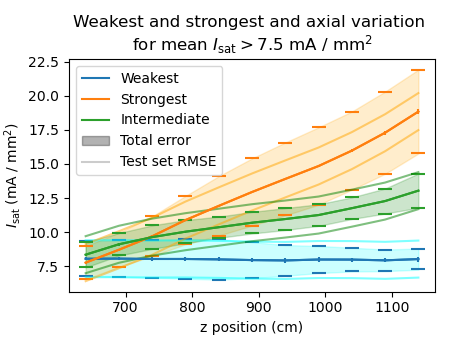

In [509]:
plt.figure(figsize=(4.5,3.5))
# plt.plot(isat_mean_005[isat_mean_005_argsort][0])
# plt.plot(isat_mean_005[isat_mean_005_argsort][-1])

plt.title('Weakest and strongest and axial variation \nfor mean $I_\mathrm{sat} > 7.5$ mA / mm$^2$')

idx1 = isat_mean_005_argsort[isat_mean_005_argsort_DR2_top_GP_off[0]]
idx2 = isat_mean_005_argsort[isat_mean_005_argsort_DR2_top_GP_off[-1]]
idx3 = isat_mean_005_argsort[isat_mean_005_argsort_DR2_top_GP_off[15000]]


# idx1 = isat_mean_005_argsort[isat_mean_005_argsort_DR2_top_GP_off[153]]
# idx2 = isat_mean_005_argsort[isat_mean_005_argsort_DR2_top_GP_off[22453]]
# idx3 = isat_mean_005_argsort[isat_mean_005_argsort_DR2_top_GP_off[15000]]

# idx2 = 48723
# idx3 = isat_mean_005_argsort[5520] - 1

# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.errorbar(z_arr, isat_mean_005[idx1] * 1e3, yerr=np.sqrt(isat_aleatoric_005[idx1]) * 1e3, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:blue')
plt.errorbar(z_arr, isat_mean_005[idx1] * 1e3, yerr=np.sqrt(isat_epistemic_005[idx1]) * 1e3, elinewidth=0, capsize=5, capthick=1.5, color='tab:blue')
plt.fill_between(z_arr, (isat_mean_005[idx1] + np.sqrt(isat_var_005[idx1])) * 1e3,
                 (isat_mean_005[idx1] - np.sqrt(isat_var_005[idx1])) * 1e3, alpha=0.2, color='cyan')
plt.plot(z_arr, (isat_mean_005[idx1] + RMSE) * 1e3, alpha=0.5, color='cyan')
plt.plot(z_arr, (isat_mean_005[idx1] - RMSE) * 1e3, alpha=0.5, color='cyan')

plt.errorbar(z_arr, isat_mean_005[idx2] * 1e3, yerr=(np.sqrt(isat_aleatoric_005[idx2])) * 1e3, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:orange')
plt.errorbar(z_arr, isat_mean_005[idx2] * 1e3, yerr=(np.sqrt(isat_epistemic_005[idx2])) * 1e3, elinewidth=0, capsize=5, capthick=1.5, color='tab:orange')
plt.fill_between(z_arr, (isat_mean_005[idx2] + np.sqrt(isat_var_005[idx2])) * 1e3,
                 (isat_mean_005[idx2] - np.sqrt(isat_var_005[idx2])) * 1e3, alpha=0.2, color='orange')
plt.plot(z_arr, (isat_mean_005[idx2] + RMSE) * 1e3, alpha=0.5, color='orange')
plt.plot(z_arr, (isat_mean_005[idx2] - RMSE) * 1e3, alpha=0.5, color='orange')

plt.errorbar(z_arr, isat_mean_005[idx3] * 1e3, yerr=(np.sqrt(isat_aleatoric_005[idx3])) * 1e3, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:green')
plt.errorbar(z_arr, isat_mean_005[idx3] * 1e3, yerr=(np.sqrt(isat_epistemic_005[idx3])) * 1e3, elinewidth=0, capsize=5, capthick=1.5, color='tab:green')
plt.fill_between(z_arr, (isat_mean_005[idx3] + np.sqrt(isat_var_005[idx3])) * 1e3,
                 (isat_mean_005[idx3] - np.sqrt(isat_var_005[idx3])) * 1e3, alpha=0.2, color='green')
plt.plot(z_arr, (isat_mean_005[idx3] + RMSE) * 1e3, alpha=0.5, color='green')
plt.plot(z_arr, (isat_mean_005[idx3] - RMSE) * 1e3, alpha=0.5, color='green')

plt.plot([], [], color='tab:blue', label='Weakest')
plt.plot([], [], color='tab:orange', label='Strongest')
plt.plot([], [], color='tab:green', label='Intermediate')

plt.fill_between([], [], [], alpha=0.3, color='black', label='Total error')
plt.plot([], [], color='black', alpha=0.2, label='Test set RMSE')

plt.ylabel(r'$I_\mathrm{sat}$ (mA / mm$^2$)')
plt.xlabel('z position (cm)')

# plt.ylim(0.0, 0.013)

plt.legend()
plt.tight_layout()

# plt.savefig('/home/phil/Desktop/profile-predict/PP1/plots/inference/best_worst_isat_0-0075_axial_var.pdf')

In [515]:
print("Weakest: {:.2f}".format(np.std(isat_mean_005[idx1] * 1e3)))
print("Strongest: {:.2f}".format(np.std(isat_mean_005[idx2] * 1e3)))
print("Intermediate: {:.2f}".format(np.std(isat_mean_005[idx3] * 1e3)))

Weakest: 0.04
Strongest: 3.42
Intermediate: 1.32


<IPython.core.display.Javascript object>


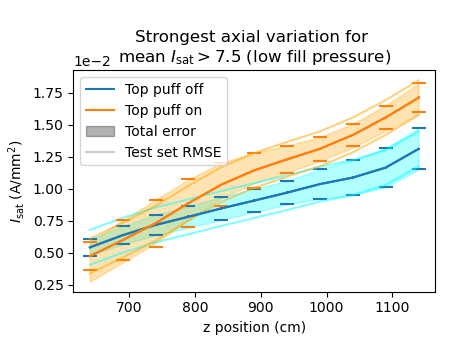

In [443]:
plt.figure(figsize=(4.5,3.5))
# plt.plot(isat_mean_005[isat_mean_005_argsort][0])
# plt.plot(isat_mean_005[isat_mean_005_argsort][-1])

plt.title('Strongest axial variation for \nmean $I_\mathrm{sat} > 7.5$ (low fill pressure)')

idx1 = isat_mean_005_argsort[56230]-1
idx2 = isat_mean_005_argsort[56230]

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.errorbar(z_arr, isat_mean_005[idx1], yerr=np.sqrt(isat_aleatoric_005[idx1]), elinewidth=1.5, capsize=0, capthick=1.5, color='tab:blue')
plt.errorbar(z_arr, isat_mean_005[idx1], yerr=np.sqrt(isat_epistemic_005[idx1]), elinewidth=0, capsize=5, capthick=1.5, color='tab:blue')
plt.fill_between(z_arr, isat_mean_005[idx1] + np.sqrt(isat_var_005[idx1]),
                 isat_mean_005[idx1] - np.sqrt(isat_var_005[idx1]), alpha=0.3, color='cyan')
plt.plot(z_arr, isat_mean_005[idx1] + RMSE, alpha=0.5, color='cyan')
plt.plot(z_arr, isat_mean_005[idx1] - RMSE, alpha=0.5, color='cyan')

plt.errorbar(z_arr, isat_mean_005[idx2], yerr=np.sqrt(isat_aleatoric_005[idx2]), elinewidth=1.5, capsize=0, capthick=1.5, color='tab:orange')
plt.errorbar(z_arr, isat_mean_005[idx2], yerr=np.sqrt(isat_epistemic_005[idx2]), elinewidth=0, capsize=5, capthick=1.5, color='tab:orange')
plt.fill_between(z_arr, isat_mean_005[idx2] + np.sqrt(isat_var_005[idx2]),
                 isat_mean_005[idx2] - np.sqrt(isat_var_005[isat_mean_005_argsort[idx2]]), alpha=0.3, color='orange')
plt.plot(z_arr, isat_mean_005[idx2] + RMSE, alpha=0.5, color='orange')
plt.plot(z_arr, isat_mean_005[idx2] - RMSE, alpha=0.5, color='orange')

plt.plot([], [], color='tab:blue', label='Top puff off')
plt.plot([], [], color='tab:orange', label='Top puff on')

plt.fill_between([], [], [], alpha=0.3, color='black', label='Total error')
plt.plot([], [], color='black', alpha=0.2, label='Test set RMSE')

plt.ylabel(r'$I_\mathrm{sat}$ (A/mm$^2$)')
plt.xlabel('z position (cm)')

# plt.ylim(0.0, 0.013)

plt.legend()
plt.tight_layout()

# plt.savefig('/home/phil/Desktop/profile-predict/PP1/plots/inference/strong_isat_0-0075_axial_var_top-puff.pdf')

In [441]:
np.mean(isat_mean_005[isat_mean_005_argsort[56230]-1] - isat_mean_005[isat_mean_005_argsort[56230]])

-0.0019050569

<IPython.core.display.Javascript object>


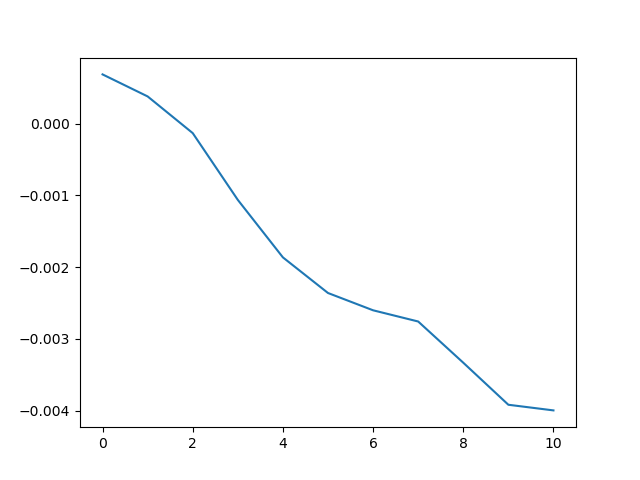

In [442]:
plt.figure()
plt.plot(isat_mean_005[isat_mean_005_argsort[56230]-1] - isat_mean_005[isat_mean_005_argsort[56230]])

# Gas puff duration on x and z profiles

In [246]:
isat_mean[s].shape

(7, 6, 6, 5, 9, 5, 1, 1, 11, 1, 2, 2)

In [247]:
# plt.figure(figsize=(5,4))

# plt.errorbar(z_arr, isat_mean[s], yerr=np.sqrt(isat_aleatoric[s]), elinewidth=1.5, capsize=0, capthick=1.5, color='tab:blue')
# plt.errorbar(z_arr, isat_mean[s], yerr=np.sqrt(isat_epistemic[s]), elinewidth=0, capsize=5, capthick=1.5, color='tab:blue')
# plt.fill_between(z_arr, isat_mean[s] + np.sqrt(isat_var[s]), isat_mean[s] - np.sqrt(isat_var[s]), alpha=0.3, color='cyan')
# # plt.fill_between(z_arr, isat_mean[s] + RMSE, isat_mean[s] - RMSE, alpha=0.2, color='cyan')
# plt.plot(z_arr, isat_mean[s] + RMSE, alpha=0.5, color='cyan')
# plt.plot(z_arr, isat_mean[s] - RMSE, alpha=0.5, color='cyan')

In [248]:
GP_duration

array([ 5.  , 13.25, 21.5 , 29.75, 38.  ])

In [251]:
s_GP_scan = np.s_[
        2,  # B_source_arr
        3,  # B_mirror_arr
        3,  # B_midplane_arr
        2,  # GP_voltage_arr
        4,  # discharge_voltage_arr
        :,  # GP_duration
        25,  # x_arr
        0,  # y_arr
        :,  # z_arr
        0,  # theta_arr
        1,  # run_set_flag
        0] # top_GP_flag

In [252]:
gp_scan_output1 = np.array([(np.sqrt(outputs[i, :, 1].reshape(*isat_shape)[s_GP_scan]) * y_ptp)/0.5*1e3 for i in range(len(models))])

In [253]:
gp_scan_output1_total = np.sqrt(gp_scan_output1[:, :, :-1] ** 2 +  gp_scan_output1[:, :, 1:])

In [254]:
gp_scan_random_var = np.sqrt(np.sum(gp_scan_output1_total[:, :, :] ** 2, axis=(0, 2))) / 50

<IPython.core.display.Javascript object>


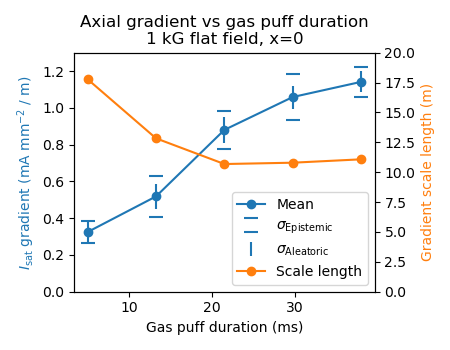

In [303]:
tab_colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple', 'tab:brown']

s_GP_scan = np.s_[
        2-0,  # B_source_arr
        3-0,  # B_mirror_arr
        3-0,  # B_midplane_arr
        4,  # discharge_voltage_arr
        2,  # GP_voltage_arr
        :,  # GP_duration
        25,  # x_arr
        0,  # y_arr
        :,  # z_arr
        0,  # theta_arr
        1,  # run_set_flag
        0] # top_GP_flag

plt.figure(figsize=(4.5,3.5))

plt.title('Axial gradient vs gas puff duration\n1 kG flat field, x=0')

gp_scan_gradient_mean = np.mean([np.mean(np.diff(outputs[i, :, 0].reshape(*isat_shape)[s_GP_scan] * y_ptp + y_mean, axis=1), axis=1) / 0.5 * 1e3 for i in range(len(models))], axis=0)
gp_scan_gradient_std = np.std([np.mean(np.diff(outputs[i, :, 0].reshape(*isat_shape)[s_GP_scan] * y_ptp + y_mean, axis=1), axis=1) / 0.5 * 1e3 for i in range(len(models))], axis=0)

ln1 = plt.plot(GP_duration, gp_scan_gradient_mean, marker='o', color='tab:blue', label='Mean')

ln2 = plt.errorbar(GP_duration, gp_scan_gradient_mean, yerr=np.sqrt(gp_scan_gradient_std ** 2), label=r'$\sigma_\mathrm{Epistemic}$', lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:blue')
ln3 = plt.errorbar(GP_duration, gp_scan_gradient_mean, yerr=np.sqrt(gp_scan_random_var ** 2), label=r'$\sigma_\mathrm{Aleatoric}$', lw=0, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:blue')

plt.ylabel(r'$I_\mathrm{sat}$ gradient (mA mm$^{-2}$ / m)')
plt.xlabel('Gas puff duration (ms)')
plt.gca().yaxis.label.set_color('tab:blue')

lines, labels = plt.gca().get_legend_handles_labels()

plt.ylim(0, 1.3)

ax1 = plt.gca().twinx()
ax1.yaxis.label.set_color('tab:orange')
ln4 = ax1.plot(GP_duration, 1/(gp_scan_gradient_mean /
                       np.mean([np.mean((outputs[i, :, 0].reshape(*isat_shape)[s_GP_scan] * y_ptp + y_mean), axis=1) / 0.5 * 1e3 for i in range(len(models))], axis=0))
         , marker='o', color='tab:orange', label='Scale length')
ax1.set_ylabel('Gradient scale length (m)')
ax1.set_ylim(0, 20)

lines1, labels1 = ax1.get_legend_handles_labels()

ax1.legend(lines + lines1, labels + labels1, loc=4)

plt.tight_layout()

# plt.savefig('plots/inference/axial-grad_gas-puff.pdf')

<IPython.core.display.Javascript object>


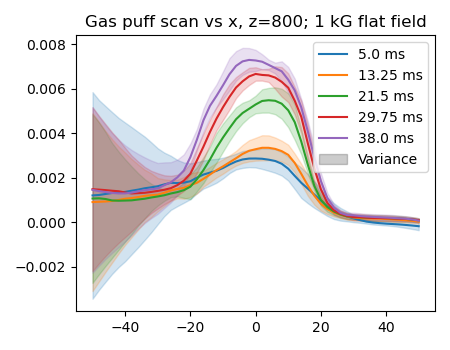

In [304]:
tab_colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

s_GP_scan = np.s_[
        2,  # B_source_arr
        3,  # B_mirror_arr
        3,  # B_midplane_arr
        2,  # GP_voltage_arr
        2,  # discharge_voltage_arr
        :,  # GP_duration
        :,  # x_arr
        0,  # y_arr
        3,  # z_arr
        0,  # theta_arr
        1,  # run_set_flag
        0] # top_GP_flag

plt.figure(figsize=(4.5,3.5))

plt.title('Gas puff scan vs x, z=800; 1 kG flat field')

for i in range(5):
    plt.plot(x_arr, isat_mean[s_GP_scan][i, :], label='{} ms'.format(GP_duration[i]))
    plt.fill_between(x_arr, isat_mean[s_GP_scan][i] + np.sqrt(isat_var[s_GP_scan][i]), isat_mean[s_GP_scan][i] - np.sqrt(isat_var[s_GP_scan][i]), alpha=0.2, color=tab_colors[i])

plt.fill_between([], [], [], color='black', alpha=0.2, label='Variance')
    
plt.legend()
plt.tight_layout()

# plt.savefig('plots/inference/profile_gas-puff.pdf')

# Mirror trends

## Reference M=3

<IPython.core.display.Javascript object>


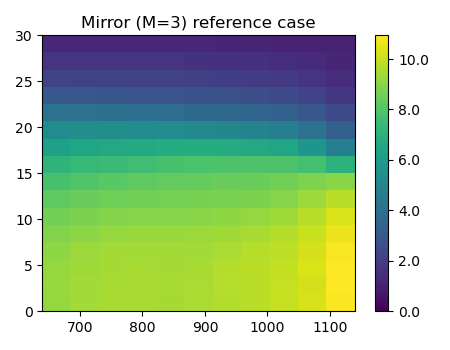

/tmp/ipykernel_405060/2883900965.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(["{:}".format(i*1e3) for i in cbar.get_ticks()])


In [266]:
s_mirror_scan = np.s_[
        0,  # B_source_arr
        5,  # B_mirror_arr
        1,  # B_midplane_arr
        0,  # GP_voltage_arr
        4,  # discharge_voltage_arr
        4,  # GP_duration
        25:41,  # x_arr
        0,  # y_arr
        :,  # z_arr
        0,  # theta_arr
        1,  # run_set_flag
        0] # top_GP_flag

plt.figure(figsize=(4.5,3.5))
plt.title('Mirror (M=3) reference case')
plt.imshow(isat_mean[s_mirror_scan], extent=[z_arr[0], z_arr[-1], x_arr[25], x_arr[40]],
           aspect='auto', origin='lower', vmin=0)
cbar = plt.colorbar()

cbar.ax.set_yticklabels(["{:}".format(i*1e3) for i in cbar.get_ticks()])

plt.tight_layout()

When the source filed is increased we'd expect the mirror to balloon out a bit by a factor of sqrt(3) ~= 1.7 which happens here

## Increasing source field

In [997]:
B_source_arr[4]

1500

<IPython.core.display.Javascript object>


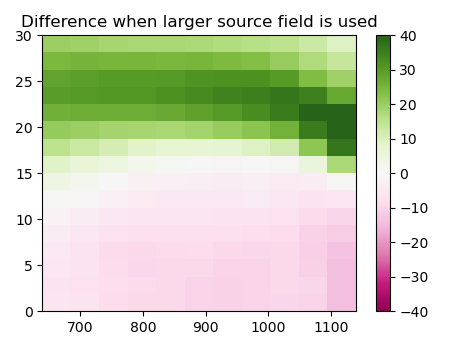

<IPython.core.display.Javascript object>


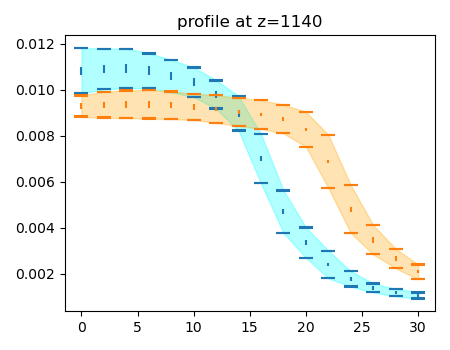

<IPython.core.display.Javascript object>


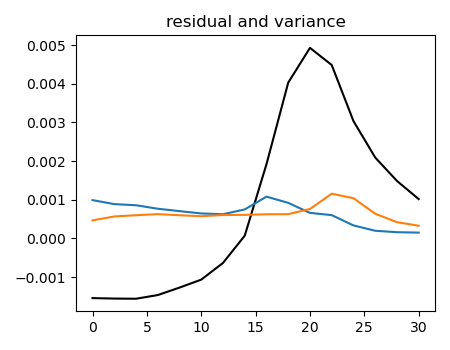

In [268]:
s_mirror_scan_bigsource = np.s_[
        4,  # B_source_arr
        5,  # B_mirror_arr
        1,  # B_midplane_arr
        0,  # GP_voltage_arr
        4,  # discharge_voltage_arr
        4,  # GP_duration
        25:41,  # x_arr
        0,  # y_arr
        :,  # z_arr
        0,  # theta_arr
        1,  # run_set_flag
        0] # top_GP_flag

plt.figure(figsize=(4.5,3.5))
plt.title('Difference when larger source field is used')
plt.imshow((isat_mean[s_mirror_scan_bigsource] - isat_mean[s_mirror_scan])/np.max(isat_mean[s_mirror_scan]) * 100, extent=[z_arr[0], z_arr[-1], x_arr[25], x_arr[40]],
           aspect='auto', origin='lower', vmin=-40, vmax=40, cmap='PiYG')
plt.colorbar()
plt.tight_layout()

plt.figure(figsize=(4.5,3.5))
plt.title("profile at z=1140")
# plt.plot(x_arr[25:41], isat_mean[s_mirror_scan][:, -1])
# plt.plot(x_arr[25:41], isat_mean[s_mirror_scan_bigsource][:, -1])

temp_s = s_mirror_scan
# plt.plot(x_arr[25:41], isat_mean[temp_s][:, -1], color='tab:blue')
plt.errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_aleatoric[temp_s][:, -1]), lw=0, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:blue')
plt.errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_epistemic[temp_s][:, -1]), lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:blue')
plt.errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_var[temp_s][:, -1]), lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:blue')
plt.fill_between(x_arr[25:41], isat_mean[temp_s][:, -1] + np.sqrt(isat_var[temp_s][:, -1]), isat_mean[temp_s][:, -1] - np.sqrt(isat_var[temp_s][:, -1]), alpha=0.3, color='cyan')
# plt.plot(x_arr[25:41], isat_mean[temp_s][:, -1] + RMSE, alpha=0.5, color='cyan')
# plt.plot(x_arr[25:41], isat_mean[temp_s][:, -1] - RMSE, alpha=0.5, color='cyan')

temp_s = s_mirror_scan_bigsource
# plt.plot(x_arr[25:41], isat_mean[temp_s][:, -1], color='tab:orange')
plt.errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_aleatoric[temp_s][:, -1]), lw=0, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:orange')
plt.errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_epistemic[temp_s][:, -1]), lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:orange')
plt.errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_var[temp_s][:, -1]), lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:orange')
plt.fill_between(x_arr[25:41], isat_mean[temp_s][:, -1] + np.sqrt(isat_var[temp_s][:, -1]), isat_mean[temp_s][:, -1] - np.sqrt(isat_var[temp_s][:, -1]), alpha=0.3, color='orange')
# plt.plot(x_arr[25:41], isat_mean[temp_s][:, -1] + RMSE, alpha=0.5, color='orange')
# plt.plot(x_arr[25:41], isat_mean[temp_s][:, -1] - RMSE, alpha=0.5, color='orange')
plt.tight_layout()

plt.figure(figsize=(4.5,3.5))
plt.title('residual and variance')
plt.plot(x_arr[25:41], isat_mean[s_mirror_scan_bigsource][:, -1] - isat_mean[s_mirror_scan][:, -1], color='black')
plt.plot(x_arr[25:41], np.sqrt(isat_var[s_mirror_scan][:, -1]))
plt.plot(x_arr[25:41], np.sqrt(isat_var[s_mirror_scan_bigsource][:, -1]))
# plt.ylim(0, 8e-4)
plt.tight_layout()

## Decrease GP duration

In [730]:
discharge_voltage_arr[4]

110

<IPython.core.display.Javascript object>


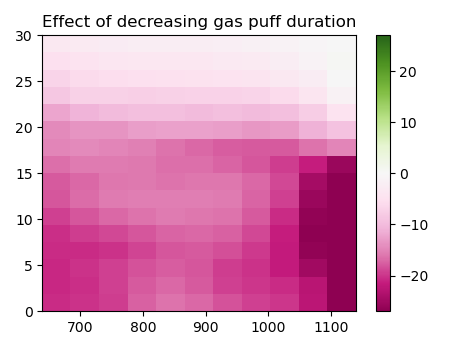

In [269]:
s_mirror_scan_lowGP = np.s_[
        0,  # B_source_arr
        5,  # B_mirror_arr
        1,  # B_midplane_arr
        0,  # GP_voltage_arr
        4,  # discharge_voltage_arr
        2,  # GP_duration
        25:41,  # x_arr
        0,  # y_arr
        :,  # z_arr
        0,  # theta_arr
        1,  # run_set_flag
        0] # top_GP_flag

plt.figure(figsize=(4.5,3.5))
plt.title('Effect of decreasing gas puff duration')
plt.imshow((isat_mean[s_mirror_scan_lowGP] - isat_mean[s_mirror_scan])/np.max(isat_mean[s_mirror_scan]) * 100, extent=[z_arr[0], z_arr[-1], x_arr[25], x_arr[40]],
           aspect='auto', origin='lower', vmin=-27, vmax=27, cmap='PiYG')
plt.colorbar()
plt.tight_layout()

## Decreasing to M=2.5

<IPython.core.display.Javascript object>


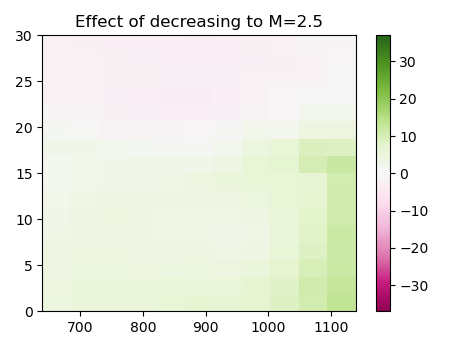

In [270]:
s_mirror_scan_lowM_2_5 = np.s_[
        0,  # B_source_arr
        4,  # B_mirror_arr
        1,  # B_midplane_arr
        0,  # GP_voltage_arr
        4,  # discharge_voltage_arr
        4,  # GP_duration
        25:41,  # x_arr
        0,  # y_arr
        :,  # z_arr
        0,  # theta_arr
        1,  # run_set_flag
        0] # top_GP_flag

plt.figure(figsize=(4.5,3.5))
plt.title('Effect of decreasing to M=2.5')
plt.imshow((isat_mean[s_mirror_scan_lowM_2_5] - isat_mean[s_mirror_scan])/np.max(isat_mean[s_mirror_scan]) * 100, extent=[z_arr[0], z_arr[-1], x_arr[25], x_arr[40]],
           aspect='auto', origin='lower', vmin=-37, vmax=37, cmap='PiYG')
plt.colorbar()
plt.tight_layout()

## Decreasing to M=2

<IPython.core.display.Javascript object>


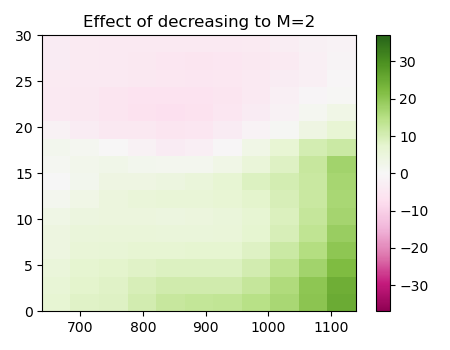

In [271]:
s_mirror_scan_lowM_2_0 = np.s_[
        0,  # B_source_arr
        3,  # B_mirror_arr
        1,  # B_midplane_arr
        0,  # GP_voltage_arr
        4,  # discharge_voltage_arr
        4,  # GP_duration
        25:41,  # x_arr
        0,  # y_arr
        :,  # z_arr
        0,  # theta_arr
        1,  # run_set_flag
        0] # top_GP_flag

plt.figure(figsize=(4.5,3.5))
plt.title('Effect of decreasing to M=2')
plt.imshow((isat_mean[s_mirror_scan_lowM_2_0] - isat_mean[s_mirror_scan])/np.max(isat_mean[s_mirror_scan]) * 100, extent=[z_arr[0], z_arr[-1], x_arr[25], x_arr[40]],
           aspect='auto', origin='lower', vmin=-37, vmax=37, cmap='PiYG')
plt.colorbar()
plt.tight_layout()

## Decreasing to M=1.5

<IPython.core.display.Javascript object>


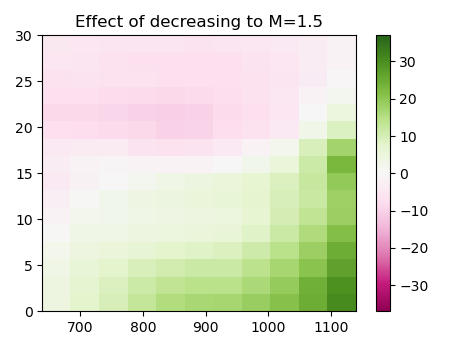

In [272]:
s_mirror_scan_lowM_1_5 = np.s_[
        0,  # B_source_arr
        2,  # B_mirror_arr
        1,  # B_midplane_arr
        0,  # GP_voltage_arr
        4,  # discharge_voltage_arr
        4,  # GP_duration
        25:41,  # x_arr
        0,  # y_arr
        :,  # z_arr
        0,  # theta_arr
        1,  # run_set_flag
        0] # top_GP_flag

plt.figure(figsize=(4.5,3.5))
plt.title('Effect of decreasing to M=1.5')
plt.imshow((isat_mean[s_mirror_scan_lowM_1_5] - isat_mean[s_mirror_scan])/np.max(isat_mean[s_mirror_scan]) * 100, extent=[z_arr[0], z_arr[-1], x_arr[25], x_arr[40]],
           aspect='auto', origin='lower', vmin=-37, vmax=37, cmap='PiYG')
plt.colorbar()
plt.tight_layout()

In [973]:
B_mirror_arr[5]

1500

In [975]:
B_midplane_arr[3]

1000

In [1151]:
GP_duration[4]

38.0

<IPython.core.display.Javascript object>


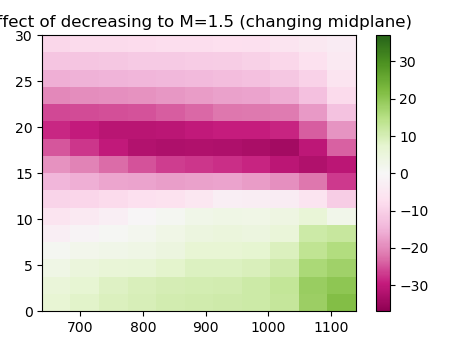

In [273]:
s_mirror_scan_lowM_1_5_midplane = np.s_[
        0,  # B_source_arr
        5,  # B_mirror_arr
        3,  # B_midplane_arr
        0,  # GP_voltage_arr
        4,  # discharge_voltage_arr
        4,  # GP_duration
        25:41,  # x_arr
        0,  # y_arr
        :,  # z_arr
        0,  # theta_arr
        1,  # run_set_flag
        0] # top_GP_flag

plt.figure(figsize=(4.5,3.5))
plt.title('Effect of decreasing to M=1.5 (changing midplane)')
plt.imshow((isat_mean[s_mirror_scan_lowM_1_5_midplane] - isat_mean[s_mirror_scan])/np.max(isat_mean[s_mirror_scan]) * 100, extent=[z_arr[0], z_arr[-1], x_arr[25], x_arr[40]],
           aspect='auto', origin='lower', vmin=-37, vmax=37, cmap='PiYG')
plt.colorbar()
plt.tight_layout()

## Plotting all together

In [274]:
isat_mean[s_mirror_scan].shape

(16, 11)

<IPython.core.display.Javascript object>


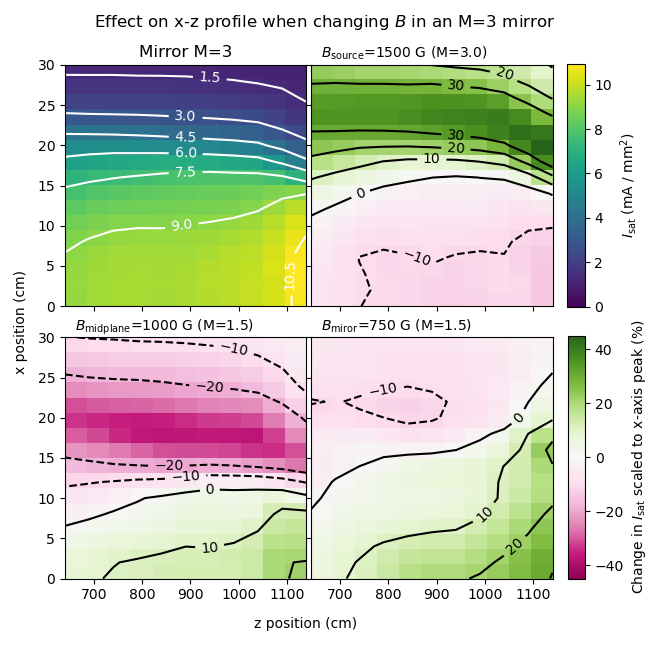

In [308]:
fig, axes = plt.subplots(2, 2, figsize=(6.5,6.5), sharex=True, sharey=True)

im_max = 45
im_min = -45

axes[0,0].set_title('Mirror M=3')
im_prof = axes[0,0].imshow(isat_mean[s_mirror_scan] * 1e3, extent=[z_arr[0], z_arr[-1], x_arr[25], x_arr[40]],
           aspect='auto', origin='lower', vmin=0)

cont = axes[0,0].contour(*np.meshgrid(z_arr[:], x_arr[25:41]), isat_mean[s_mirror_scan] * 1e3, colors='white')
axes[0,0].clabel(cont, cont.levels, inline=True)


axes[0,1].text(660, 32.5, '$B_\mathrm{source}$=1500 G (M=3.0)', ha='left', va='top')
axes[0,1].imshow((isat_mean[s_mirror_scan_bigsource] - isat_mean[s_mirror_scan])/np.max(isat_mean[s_mirror_scan], axis=0, keepdims=True) * 100, extent=[z_arr[0], z_arr[-1], x_arr[25], x_arr[40]],
           aspect='auto', origin='lower', vmin=im_min, vmax=im_max, cmap='PiYG')
cont = axes[0,1].contour(*np.meshgrid(z_arr[:], x_arr[25:41]), (isat_mean[s_mirror_scan_bigsource] - isat_mean[s_mirror_scan])/np.max(isat_mean[s_mirror_scan], axis=0, keepdims=True) * 100, colors='black',
                        levels=[-20, -10, 0, 10, 20, 30])
axes[0,1].clabel(cont, cont.levels, inline=True)


axes[1,0].text(660, 32.5, '$B_\mathrm{midplane}$=1000 G (M=1.5)', ha='left', va='top')
axes[1,0].imshow((isat_mean[s_mirror_scan_lowM_1_5_midplane] - isat_mean[s_mirror_scan])/np.max(isat_mean[s_mirror_scan], axis=0, keepdims=True) * 100, extent=[z_arr[0], z_arr[-1], x_arr[25], x_arr[40]],
           aspect='auto', origin='lower', vmin=im_min, vmax=im_max, cmap='PiYG')
cont = axes[1,0].contour(*np.meshgrid(z_arr[:], x_arr[25:41]), (isat_mean[s_mirror_scan_lowM_1_5_midplane] - isat_mean[s_mirror_scan])/np.max(isat_mean[s_mirror_scan], axis=0, keepdims=True) * 100, colors='black',
                        levels=[-20, -10, 0, 10, 20, 30])
axes[1,0].clabel(cont, cont.levels, inline=True)


axes[1, 1].text(660, 32.5, '$B_\mathrm{miror}$=750 G (M=1.5)', ha='left', va='top')
im = axes[1, 1].imshow((isat_mean[s_mirror_scan_lowM_1_5] - isat_mean[s_mirror_scan])/np.max(isat_mean[s_mirror_scan], axis=0, keepdims=True) * 100, extent=[z_arr[0], z_arr[-1], x_arr[25], x_arr[40]],
           aspect='auto', origin='lower', vmin=im_min, vmax=im_max, cmap='PiYG')
cont = axes[1,1].contour(*np.meshgrid(z_arr[:], x_arr[25:41]), (isat_mean[s_mirror_scan_lowM_1_5] - isat_mean[s_mirror_scan])/np.max(isat_mean[s_mirror_scan], axis=0, keepdims=True) * 100, colors='black',
                        levels=[-20, -10, 0, 10, 20, 30])
axes[1,1].clabel(cont, cont.levels, inline=True)

# axes[1,1].set_xlabel('z position (cm)')
# axes[0,0].set_ylabel('x position (cm)')
# axes[1,0].set_xlabel('z position (cm)')
# axes[1,0].set_ylabel('x position (cm)')

fig.text(0.47, 0.034, 'z position (cm)', ha='center')
fig.text(0.032, 0.43, 'x position (cm)', ha='center', rotation='vertical')

fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.05, aspect=14, shrink=0.485, label='Change in $I_\mathrm{sat}$ scaled to x-axis peak (%)', anchor=(1.0, 0.0))
fig.colorbar(im_prof, ax=axes.ravel().tolist(), fraction=0.05, aspect=14, shrink=0.485, label='$I_\mathrm{sat}$ (mA / mm$^2$)', anchor=(10.4, 1.055))

fig.subplots_adjust(wspace=0.02, hspace=0.13, right=0.85, top=0.9, left=0.1)

fig.suptitle('Effect on x-z profile when changing $B$ in an M=3 mirror')

# plt.savefig('plots/inference/changing-B-field_M=3_xz-prof.pdf')

<IPython.core.display.Javascript object>


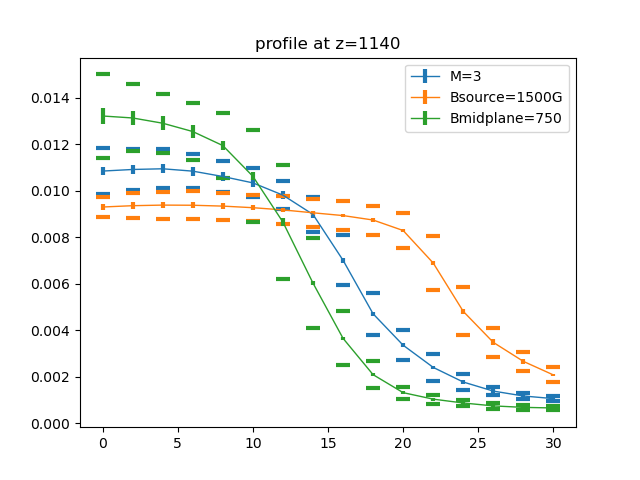

In [280]:
plt.figure()
plt.title("profile at z=1140")
# plt.plot(x_arr[25:41], isat_mean[s_mirror_scan][:, -1])
# plt.plot(x_arr[25:41], isat_mean[s_mirror_scan_bigsource][:, -1])

temp_s = s_mirror_scan
# plt.plot(x_arr[25:41], isat_mean[temp_s][:, -1], color='tab:blue')
plt.errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_aleatoric[temp_s][:, -1]), lw=1, elinewidth=3, capsize=0, capthick=3, color='tab:blue', label='M=3')
plt.errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_epistemic[temp_s][:, -1]), lw=0, elinewidth=0, capsize=5, capthick=3, color='tab:blue')
# axes[2,0].errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_var[temp_s][:, -1]), lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:blue')
# axes[2,0].fill_between(x_arr[25:41], isat_mean[temp_s][:, -1] + np.sqrt(isat_var[temp_s][:, -1]), isat_mean[temp_s][:, -1] - np.sqrt(isat_var[temp_s][:, -1]), alpha=0.3, color='cyan')
# plt.plot(x_arr[25:41], isat_mean[temp_s][:, -1] + RMSE, alpha=0.5, color='cyan')
# plt.plot(x_arr[25:41], isat_mean[temp_s][:, -1] - RMSE, alpha=0.5, color='cyan')

temp_s = s_mirror_scan_bigsource
# plt.plot(x_arr[25:41], isat_mean[temp_s][:, -1], color='tab:orange')
plt.errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_aleatoric[temp_s][:, -1]), lw=1, elinewidth=3, capsize=0, capthick=3, color='tab:orange', label='Bsource=1500G')
plt.errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_epistemic[temp_s][:, -1]), lw=0, elinewidth=0, capsize=5, capthick=3, color='tab:orange')
# axes[2,0].errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_var[temp_s][:, -1]), lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:orange')
# axes[2,0].fill_between(x_arr[25:41], isat_mean[temp_s][:, -1] + np.sqrt(isat_var[temp_s][:, -1]), isat_mean[temp_s][:, -1] - np.sqrt(isat_var[temp_s][:, -1]), alpha=0.3, color='orange')
# plt.plot(x_arr[25:41], isat_mean[temp_s][:, -1] + RMSE, alpha=0.5, color='orange')
# plt.plot(x_arr[25:41], isat_mean[temp_s][:, -1] - RMSE, alpha=0.5, color='orange')

temp_s = s_mirror_scan_lowM_1_5_midplane
plt.errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_aleatoric[temp_s][:, -1]), lw=1, elinewidth=3, capsize=0, capthick=3, color='tab:green', label='Bmidplane=750')
plt.errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_epistemic[temp_s][:, -1]), lw=0, elinewidth=0, capsize=5, capthick=3, color='tab:green')
# axes[2,0].errorbar(x_arr[25:41], isat_mean[temp_s][:, -1], yerr=np.sqrt(isat_var[temp_s][:, -1]), lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:green')
# axes[2,0].fill_between(x_arr[25:41], isat_mean[temp_s][:, -1] + np.sqrt(isat_var[temp_s][:, -1]), isat_mean[temp_s][:, -1] - np.sqrt(isat_var[temp_s][:, -1]), alpha=0.3, color='green')

plt.legend()

# Discharge voltage changes

## 1 kG flat field

In [281]:
discharge_voltage_arr

array([ 70,  80,  90, 100, 110, 120, 130, 140, 150])

In [282]:
z_arr[4]

840.0

In [283]:
x_arr[25]

0.0

In [284]:
cmap = matplotlib.colormaps['GnBu']
GnBu_colors = cmap(np.linspace(0.9, 0.2, 9))

cmap = matplotlib.colormaps['YlGnBu']
YlGnBu_colors = cmap(np.linspace(0.9, 0.2, 9))

<IPython.core.display.Javascript object>


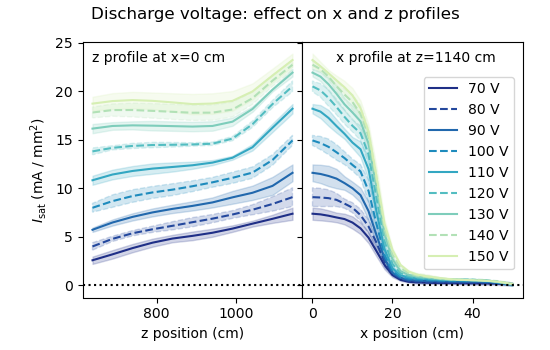

In [323]:
fig, ax = plt.subplots(1, 2, figsize=(5.5,3.5), sharey='row', sharex='col')

s_discharge_voltage = np.s_[1,  # B_source_arr
          3,  # B_mirror_arr
          3,  # B_midplane_arr
          2,  # GP_voltage_arr
          :,  # discharge_voltage_arr
          4,  # GP_duration
          :,  # x_arr
          0,  # y_arr
          :,  # z_arr
          0,  # theta_arr
          1,  # run_set_flag
          0] # top_GP_flag

for i in range(len(discharge_voltage_arr)):
    ax[1].plot(x_arr[25:], isat_mean[s_discharge_voltage][i][25:, -1] * 1e3, color=YlGnBu_colors[i], linestyle='solid' if i%2==0 else 'dashed',
               label='{} V'.format(discharge_voltage_arr[i]))
    ax[1].fill_between(x_arr[25:],
                       (isat_mean[s_discharge_voltage][i][25:, -1] + np.sqrt(isat_var[s_discharge_voltage][i][25:, -1])) * 1e3,
                       (isat_mean[s_discharge_voltage][i][25:, -1] - np.sqrt(isat_var[s_discharge_voltage][i][25:, -1])) * 1e3,
                       color=YlGnBu_colors[i], alpha=0.2, linestyle='solid' if i%2==0 else 'dashed')
#     ax[1, 1].plot(x_arr[25:], np.sqrt(isat_var[s_discharge_voltage][i][25:, -1]) * 1e3, color=YlGnBu_colors[i], linestyle='solid' if i%2==0 else 'dashed',
#                label='{} V'.format(discharge_voltage_arr[i]))

for i in range(len(discharge_voltage_arr)):
    ax[0].plot(z_arr, isat_mean[s_discharge_voltage][i][25, :] * 1e3, color=YlGnBu_colors[i], linestyle='solid' if i%2==0 else 'dashed',
               label='{} V'.format(discharge_voltage_arr[i]))
    ax[0].fill_between(z_arr,
                       (isat_mean[s_discharge_voltage][i][25, :] + np.sqrt(isat_var[s_discharge_voltage][i][25, :])) * 1e3,
                       (isat_mean[s_discharge_voltage][i][25, :] - np.sqrt(isat_var[s_discharge_voltage][i][25, :])) * 1e3,
                       color=YlGnBu_colors[i], alpha=0.2, linestyle='solid' if i%2==0 else 'dashed')
#     ax[1, 0].plot(z_arr, (np.sqrt(isat_var[s_discharge_voltage][i][25, :])) * 1e3, color=YlGnBu_colors[i], linestyle='solid' if i%2==0 else 'dashed',
#                label='{} V'.format(discharge_voltage_arr[i]))
#     ax[1, 0].set_yscale('log')
    
    
    
ax[0].axhline(0, linestyle='dotted', color='black')
ax[1].axhline(0, linestyle='dotted', color='black')

ax[0].set_xlabel('z position (cm)')
ax[1].set_xlabel('x position (cm)')
ax[0].set_ylabel(r'$I_\mathrm{sat}$ (mA / mm$^2$)')

ax[1].legend(loc=(0.55, 0.11))
# ax[1].legend(ncols=3, loc=(-0.7,0.8))

ax[0].text(640, 23, 'z profile at x=0 cm')
ax[1].text(6, 23, 'x profile at z=1140 cm')

# ax[0].set_ylim(-1, 10)

fig.suptitle('Discharge voltage: effect on x and z profiles', va='top')
fig.subplots_adjust(hspace=0, wspace=0, bottom=0.15, right=0.95, left=0.15)
    
# plt.savefig('plots/inference/discharge_voltage_effect.pdf')

In [76]:
for i in range(len(x_ptp)):
    print("{:.2f}".format(x_ptp[i]))

1500.00
1250.00
1250.00
20.00
80.00
33.00
76.66
33.01
511.20
1.02
1.00
1.00


<IPython.core.display.Javascript object>


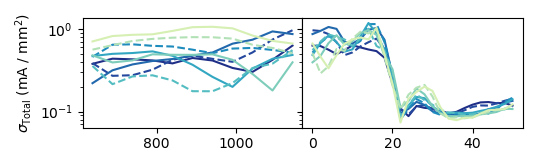

In [322]:
fig, ax = plt.subplots(1, 2, figsize=(5.5,1.5), sharey='row', sharex='col')

s_discharge_voltage = np.s_[1,  # B_source_arr
          3,  # B_mirror_arr
          3,  # B_midplane_arr
          2,  # GP_voltage_arr
          :,  # discharge_voltage_arr
          4,  # GP_duration
          :,  # x_arr
          0,  # y_arr
          :,  # z_arr
          0,  # theta_arr
          1,  # run_set_flag
          0] # top_GP_flag

for i in range(len(discharge_voltage_arr)):
    ax[1].plot(x_arr[25:], np.sqrt(isat_var[s_discharge_voltage][i][25:, -1]) * 1e3, color=YlGnBu_colors[i], linestyle='solid' if i%2==0 else 'dashed',
               label='{} V'.format(discharge_voltage_arr[i]))

for i in range(len(discharge_voltage_arr)):
    ax[0].plot(z_arr, (np.sqrt(isat_var[s_discharge_voltage][i][25, :])) * 1e3, color=YlGnBu_colors[i], linestyle='solid' if i%2==0 else 'dashed',
               label='{} V'.format(discharge_voltage_arr[i]))
    ax[0].set_yscale('log')
    
ax[0].set_ylabel(r'$\sigma_\mathrm{Total}$ (mA / mm$^2$)')
# ax[0].set_ylim(-1, 10)
fig.subplots_adjust(hspace=0, wspace=0, bottom=0.15, right=0.95, left=0.15)
    
# plt.savefig('plots/inference/discharge_voltage_effect_var-only.pdf')

# Misc plots

<IPython.core.display.Javascript object>


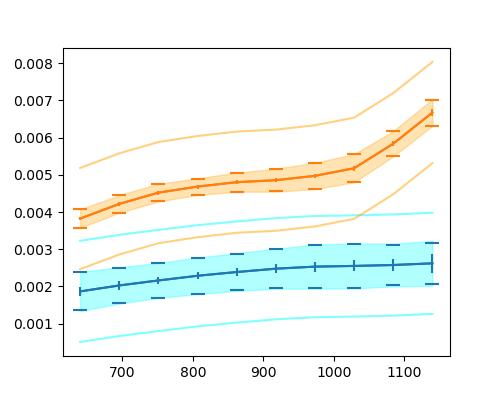

In [60]:
plt.figure(figsize=(5,4))

s = np.s_[-1,  # B_source_arr
          -3,  # B_mirror_arr
          -3,  # B_midplane_arr
          0,  # discharge_voltage_arr
          0,  # GP_voltage_arr
          0,  # GP_duration
          25,  # x_arr
          0,  # y_arr
          :,  # z_arr
          0,  # theta_arr
          1,  # run_set_flag
          0] # top_GP_flag

plt.errorbar(z_arr, isat_mean[s], yerr=np.sqrt(isat_aleatoric[s]), elinewidth=1.5, capsize=0, capthick=1.5, color='tab:blue')
plt.errorbar(z_arr, isat_mean[s], yerr=np.sqrt(isat_epistemic[s]), elinewidth=0, capsize=5, capthick=1.5, color='tab:blue')
plt.fill_between(z_arr, isat_mean[s] + np.sqrt(isat_var[s]), isat_mean[s] - np.sqrt(isat_var[s]), alpha=0.3, color='cyan')
# plt.fill_between(z_arr, isat_mean[s] + RMSE, isat_mean[s] - RMSE, alpha=0.2, color='cyan')
plt.plot(z_arr, isat_mean[s] + RMSE, alpha=0.5, color='cyan')
plt.plot(z_arr, isat_mean[s] - RMSE, alpha=0.5, color='cyan')

s = np.s_[-1,  # B_source_arr
          -3,  # B_mirror_arr
          -3,  # B_midplane_arr
          0,  # discharge_voltage_arr
          0,  # GP_voltage_arr
          -1,  # GP_duration
          25,  # x_arr
          0,  # y_arr
          :,  # z_arr
          0,  # theta_arr
          1,  # run_set_flag
          0] # top_GP_flag

plt.errorbar(z_arr, isat_mean[s], yerr=np.sqrt(isat_aleatoric[s]), elinewidth=1.5, capsize=0, capthick=1.5, color='tab:orange')
plt.errorbar(z_arr, isat_mean[s], yerr=np.sqrt(isat_epistemic[s]), elinewidth=0, capsize=5, capthick=1.5, color='tab:orange')
plt.fill_between(z_arr, isat_mean[s] + np.sqrt(isat_var[s]), isat_mean[s] - np.sqrt(isat_var[s]), alpha=0.3, color='orange')
plt.plot(z_arr, isat_mean[s] + RMSE, alpha=0.5, color='orange')
plt.plot(z_arr, isat_mean[s] - RMSE, alpha=0.5, color='orange')

<IPython.core.display.Javascript object>


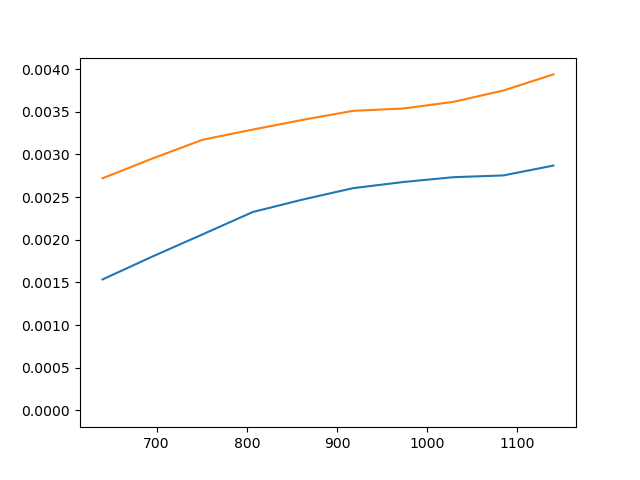

In [49]:
plt.figure()
plt.plot(z_arr, isat_output[0,
                            0,  # B_source_arr
                            0,  # B_mirror_arr
                            0,  # B_midplane_arr
                            0,  # discharge_voltage_arr
                            0,  # GP_voltage_arr
                            0,  # GP_duration
                            0,  # x_arr
                            0,  # y_arr
                            :,  # z_arr
                            0,  # theta_arr
                            1,  # run_set_flag
                            0]) # top_GP_flag

plt.plot(z_arr, isat_output[0,
                            0,  # B_source_arr
                            0,  # B_mirror_arr
                            0,  # B_midplane_arr
                            0,  # discharge_voltage_arr
                            -1,  # GP_voltage_arr
                            0,  # GP_duration
                            0,  # x_arr
                            0,  # y_arr
                            :,  # z_arr
                            0,  # theta_arr
                            1,  # run_set_flag
                            0]) # top_GP_flag

plt.plot([800],[0])

In [60]:
GP_voltage_arr

array([ 70,  75,  80,  85,  90,  95, 100])

In [30]:
plot_arr.shape

(5, 5, 10)

<IPython.core.display.Javascript object>


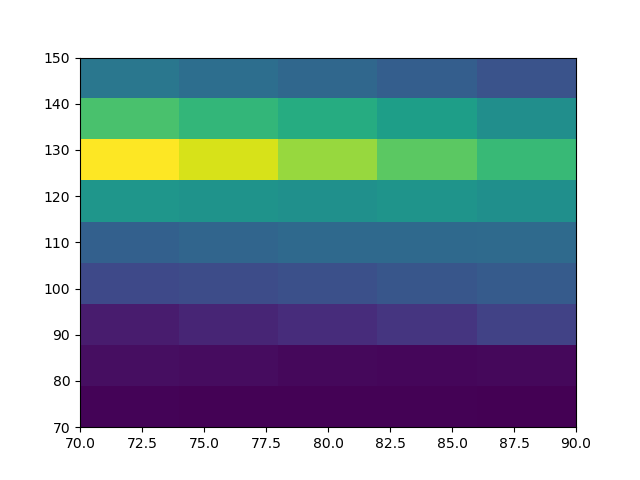

In [111]:
plot_arr = isat_output[0,  # B_source_arr
                        0,  # B_mirror_arr
                        0,  # B_midplane_arr
                        :,  # discharge_voltage_arr
                        :,  # GP_voltage_arr
                        0,  # GP_duration
                        0,  # x_arr
                        0,  # y_arr
                        :,  # z_arr
                        0,  # theta_arr
                        1,  # run_set_flag
                        0]  # top_GP_flag

plt.figure()

plt.imshow(np.ptp(plot_arr, axis=2) / np.mean(plot_arr, axis=2), extent=(GP_voltage_arr[0], GP_voltage_arr[-1], discharge_voltage_arr[0], discharge_voltage_arr[-1]),
           aspect='auto', origin='lower')

# plt.imshow(np.max(plot_arr, axis=2), extent=(GP_voltage_arr[0], GP_voltage_arr[-1], discharge_voltage_arr[0], discharge_voltage_arr[-1]),
#            aspect='auto', origin='lower')

In [85]:
np.ptp(isat_output[:,  # B_source_arr
                   :,  # B_mirror_arr
                   :,  # B_midplane_arr
                   :,  # discharge_voltage_arr
                   :,  # GP_voltage_arr
                   :,  # GP_duration
                   :,  # x_arr
                   :,  # y_arr
                   :,  # z_arr
                   :,  # theta_arr
                   :,  # run_set_flag
                   :], # top_GP_flag)
      axis=8)

array([0.00059941, 0.00098136, 0.00037834, ..., 0.00103005, 0.00088047,
       0.00058232], dtype=float32)

In [92]:
GP_duration

array([ 5.  , 13.25, 21.5 , 29.75, 38.  ])

In [115]:
0.054*y_ptp

0.0013594209104776382

<IPython.core.display.Javascript object>


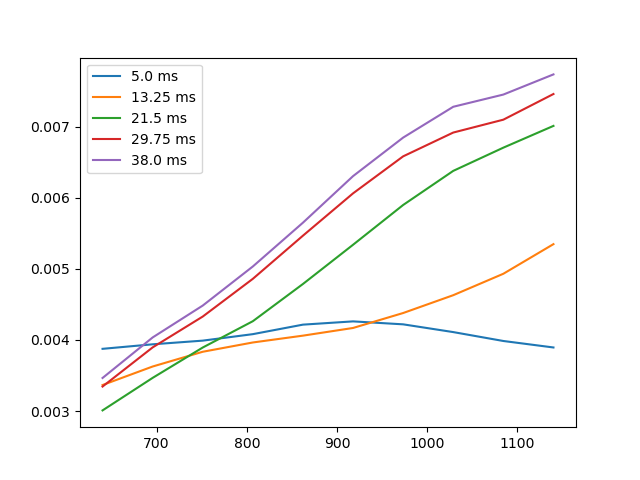

In [112]:
plt.figure()

for i in range(len(GP_duration)):
    plt.plot(z_arr, isat_output[0,  # B_source_arr
                                0,  # B_mirror_arr
                                0,  # B_midplane_arr
                                0,  # discharge_voltage_arr
                                -1,  # GP_voltage_arr
                                i,  # GP_duration
                                0,  # x_arr
                                0,  # y_arr
                                :,  # z_arr
                                0,  # theta_arr
                                1,  # run_set_flag
                                0], # top_GP_flag
             label="{} ms".format(GP_duration[i]))

plt.legend()

In [106]:
print("B_source_arr: {}".format(B_source_arr))
print("B_mirror_arr: {}".format(B_mirror_arr))
print("B_midplane_arr: {}".format(B_midplane_arr))
print("discharge_voltage_arr: {}".format(discharge_voltage_arr))
print("GP_voltage_arr: {}".format(GP_voltage_arr))
print("GP_duration: {}".format(GP_duration))
print("x_arr: {}".format(x_arr))
print("y_arr: {}".format(y_arr))
print("z_arr: {}".format(z_arr))
print("theta_arr: {}".format(theta_arr))
print("run_set_flag: {}".format(run_set_flag))
print("top_GP_flag: {}".format(top_GP_flag))

B_source_arr: [ 500  750 1000 1250 1500 1750 2000]
B_mirror_arr: [ 250  500  750 1000 1250 1500]
B_midplane_arr: [ 250  500  750 1000 1250 1500]
discharge_voltage_arr: [ 70  80  90 100 110 120 130 140 150]
GP_voltage_arr: [70 75 80 85 90]
GP_duration: [ 5.   13.25 21.5  29.75 38.  ]
x_arr: [0]
y_arr: [0]
z_arr: [ 640.          695.55555556  751.11111111  806.66666667  862.22222222
  917.77777778  973.33333333 1028.88888889 1084.44444444 1140.        ]
theta_arr: [0]
run_set_flag: [0 1]
top_GP_flag: [0 1]


<IPython.core.display.Javascript object>


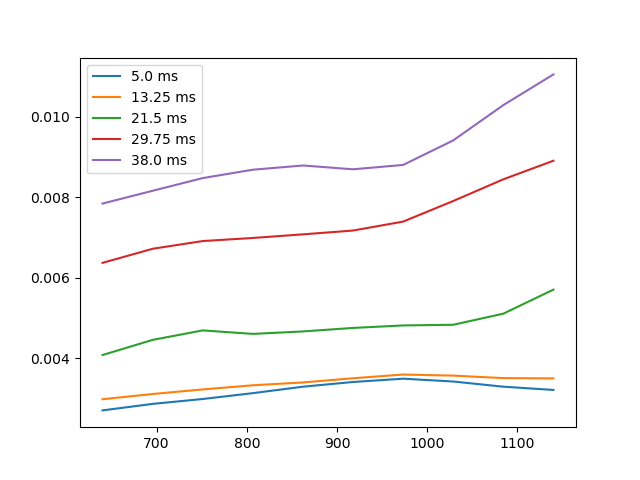

In [113]:
plt.figure()

for i in range(len(GP_duration)):
    plt.plot(z_arr, isat_output[6,  # B_source_arr
                                3,  # B_mirror_arr
                                5,  # B_midplane_arr
                                0,  # discharge_voltage_arr
                                -1,  # GP_voltage_arr
                                i,  # GP_duration
                                0,  # x_arr
                                0,  # y_arr
                                :,  # z_arr
                                0,  # theta_arr
                                1,  # run_set_flag
                                0], # top_GP_flag
             label="{} ms".format(GP_duration[i]))

plt.legend()